In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import pppc
from pppc.configs import InferenceConfigDict
from pppc.ptychonn.model import PtychoNNModel
from pppc.reconstructor import DatasetInferencer, TileStitcher
from pppc.position_list import ProbePositionList
from pppc.io import NPZFileHandle

os.chdir('/data/programs/probe_position_correction_w_ptychonn/workspace/large')

[2023-12-05 15:13:10,750] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-12-05 15:13:10,754] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
scan_idx = 235
save_figs = True

In [5]:
psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
config_dict = InferenceConfigDict()
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
#config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_zeroPad/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
config_dict['batch_size'] = 32
config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['cpu_only'] = True
config_dict['prediction_output_path'] = 'outputs/pred_{}_{}'.format(
    os.path.splitext(os.path.basename(config_dict['dp_data_file_handle'].f.fid.name))[0],
    os.path.basename(os.path.dirname(config_dict['model_path'])))

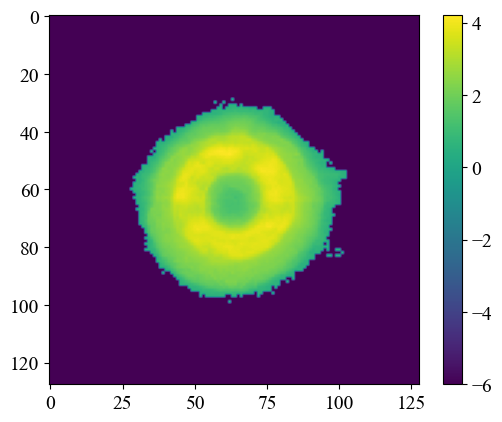

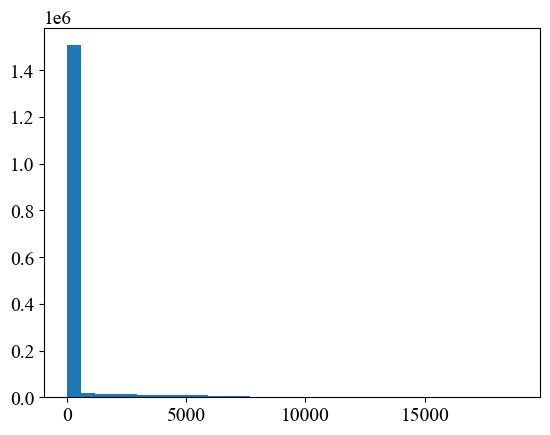

In [6]:
def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.show()
    
plt.imshow(np.log10(config_dict['dp_data_file_handle'].array[0, :, :] + 1e-6))
plt.colorbar()
plt.show()
plot_distribution(config_dict['dp_data_file_handle'].array[:100, :, :])

In [7]:
inferencer = DatasetInferencer(config_dict)
inferencer.build()
inferencer.run()
inferencer.convert_output_files_into_single_tiff('pred_phase')
inferencer.convert_output_files_into_single_tiff('pred_amp')

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 929/961 [00:22<00:00, 41.52it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/data/programs/probe_position_correction_w_ptychonn/workspace/large/outputs/pred_test235_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase_961.tiff'

In [ ]:
#config_dict['probe_position_list'] = ProbePositionList(file_path='data/pos235.csv', unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
config_dict['probe_position_list'] = ProbePositionList(file_path='outputs/test{}/calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx, scan_idx), unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
#config_dict['probe_position_list'].array += 50 * 8e-9
config_dict['central_crop'] = (108, 108)

In [ ]:
stitcher = TileStitcher(config_dict)
stitcher.build()
stitcher.run()

In [ ]:
image_stitched_ptychonn = stitcher.image_stitched
fig, ax = plt.subplots(1, 1)
im = ax.imshow(image_stitched_ptychonn)
plt.colorbar(im)
if save_figs:
    plt.savefig('outputs/test{}/stitched_niters_2_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx))
else:
    plt.show()